## Data Preparation

In [79]:
pip install shutill

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutill
import cv2
import matplotlib.image as mping
import seaborn as sns
import imutils
%matplotlib inline
plt.style.use('ggplot')

In [81]:
# Dataset
import zipfile

z = zipfile.ZipFile('Brain Tumor Classification.zip')
z.extractall()

In [82]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "Y_" + str(count) + ".jpg"
  os.rename(source, destination)
  count += 1
print("All files in the yes directory are renamed")



All files in the yes directory are renamed


In [83]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "N_" + str(count) + ".jpg"
  os.rename(source, destination)
  count += 1
print("All files in the no directory are renamed")



All files in the no directory are renamed


## Exploratory Data Analysis

In [84]:
yes_list = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(yes_list)
print("Number of files in the yes directory: ", number_files_yes)

no_list = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(no_list)
print("Number of files in the no directory: ", number_files_no)

Number of files in the yes directory:  192
Number of files in the no directory:  125


In [85]:
round(number_files_yes / (number_files_yes + number_files_no),2)

0.61

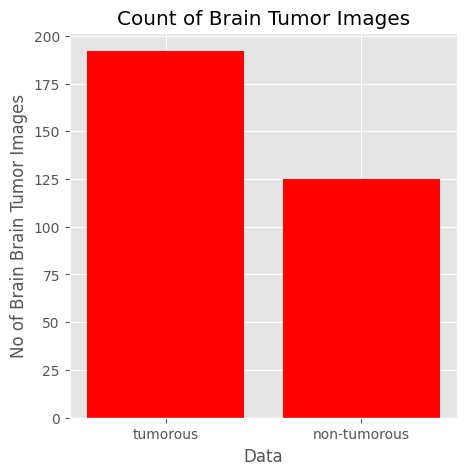

In [86]:
# Plot
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}
typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,5))
plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [87]:
# The number of data is considered small if we want to do deep learning tasks.
# So we may do data augmentation

## Data Augmentation

In [88]:
# yes : 155(61%)
# no  : 98(39%)
# somewhat imbalance

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [89]:
# "brain_tumor_dataset/yes/Y_1.jpg"
# N, WIDTH, HEIGHT, CHANNEL

In [90]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
  data_gen = ImageDataGenerator(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     brightness_range=(0.3, 0.1),
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')

  for filename in os.listdir(file_dir):
    image = cv2.imread(file_dir + '/' + filename)
    image = image.reshape((1,)+image.shape)
    save_prefix = 'aug_'+ filename[:-4] #[:-4] mean .jpg is removed
    i=0
    for batch in data_gen.flow(x=image,
                               batch_size=1,
                               save_to_dir=save_to_dir,
                               save_prefix=save_prefix,
                               save_format='jpg'):
      i += 1
      if i > n_generated_samples:
        break

In [91]:
def timer(sec_elapsed):
  h = int((sec_elapsed) / (60*60))
  m = int(sec_elapsed % (60*60) / 60)
  s = sec_elapsed % 60
  return f"{h}:{m}:{s}"

In [92]:
# prompt: remove augmented_data directory

import shutil

if os.path.exists('augmented_data'):
  shutil.rmtree('augmented_data')

In [93]:
if not os.path.exists("augmented_data"):
  os.makedirs("augmented_data")

if not os.path.exists("augmented_data/yes"):
  os.makedirs("augmented_data/yes")
  print("Created directory: augmented_data/yes")

if not os.path.exists("augmented_data/no"):
  os.makedirs("augmented_data/no")
  print("Created directory: augmented_data/no")

Created directory: augmented_data/yes
Created directory: augmented_data/no


In [94]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'
augmented_data_path = 'augmented_data/'

augmented_data(file_dir=yes_path,
               n_generated_samples=6,
               save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir=no_path,
               n_generated_samples=9,
               save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(f"Elapsed time: {timer(execution_time)}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-94-181305194.py", line 11, in <cell line: 0>
    augmented_data(file_dir=no_path,
  File "/tmp/ipython-input-90-3380782538.py", line 16, in augmented_data
    for batch in data_gen.flow(x=image,
  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 112, in __next__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 662, in _get_batches_of_transformed_samples
    img = image_utils.array_to_img(
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/image_utils.py", line 70, in array_to_img
    dtype = backend.floa

TypeError: object of type 'NoneType' has no len()

In [ ]:
def data_summary(main_path):
  yes_path = "augmented_data/yes"
  no_path = "augmented_data/no"

  n_pos = len(os.listdir(yes_path))
  n_neg = len(os.listdir(no_path))

  n = (n_pos + n_neg)

  pos_per = (n_pos*100)/n
  neg_per = (n_neg*100)/n

  print(f"Total number of images: {n}")
  print(f"Number of positive images: {n_pos} ({round(pos_per,2)}%)")
  print(f"Number of negative images: {n_neg} ({round(neg_per,2)}%)")


In [ ]:
data_summary(augmented_data_path)

In [ ]:
yes_list = os.listdir("augmented_data/yes/")
number_files_yes = len(yes_list)
print("Number of files in the yes directory: ", number_files_yes)

no_list = os.listdir("augmented_data/no/")
number_files_no = len(no_list)
print("Number of files in the no directory: ", number_files_no)

In [ ]:
# Plot
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}
typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,3))
plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
# Now we have many data, and the class are quite balanced

## Data Preprocessing

In [ ]:
# Convert RGB TO GRA
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Countours

In [ ]:
def crop_brain_tumor(image, plot=False):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (5,5), 0)
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  ext_left = tuple(c[c[:,:,0].argmin()][0])
  ext_right = tuple(c[c[:,:,0].argmax()][0])
  ext_top = tuple(c[c[:,:,1].argmin()][0])
  ext_bot = tuple(c[c[:,:,1].argmax()][0])

  new_image = image[ext_top[1]:ext_bot[1], ext_left[0]:ext_right[0]]
  return new_image

In [ ]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
  image = cv2.imread(folder1 + '/' + filename)
  image = crop_brain_tumor(image, plot=False)
  cv2.imwrite(folder1 + '/' + filename, image)
for filename in os.listdir(folder2):
  image = cv2.imread(folder2 + '/' + filename)
  image = crop_brain_tumor(image, plot=False)
  cv2.imwrite(folder2 + '/' + filename, image)

In [ ]:
# image loading
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
  X = []
  y = []
  image_width, image_height = image_size

  for directory in dir_list:
    for filename in os.listdir(directory):
      image = cv2.imread(directory + '/' + filename)
      image = crop_brain_tumor(image, plot=False)
      image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
      image = image / 255.00
      X.append(image)
      if directory[-3:] == 'yes':
        y.append(1)
      else:
        y.append(0)

  X = np.array(X)
  y = np.array(y)

  X,y = shuffle(X,y)
  print(f'Number of examples is: {len(X)}')
  print(f'Number of labels is: {len(y)}')
  print(f'X shape: {X.shape}')
  print(f'y shape: {y.shape}')
  return X, y

In [ ]:
augmented_path = 'augmented_data/'
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
# Data Splitting
# Train
# Test
# Validation

In [ ]:
if not os.path.isdir('tumorous_and_nontumorus'):
  base_dir = 'tumorous_and_nontumorus'
  os.mkdir(base_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorus/train'):
  train_dir = os.path.join(base_dir, 'train')
  os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorus/test'):
  test_dir = os.path.join(base_dir, 'test')
  os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorus/validation'):
  validation_dir = os.path.join(base_dir, 'validation')
  os.mkdir(validation_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorus/train/tumorous'):
  infected_train_dir = os.path.join(train_dir, 'tumorous')
  os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorus/test/tumorous'):
  infected_test_dir = os.path.join(test_dir, 'tumorous')
  os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorus/validation/tumorous'):
  infected_validation_dir = os.path.join(validation_dir, 'tumorous')
  os.mkdir(infected_validation_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorus/train/non_tumorous'):
  healthy_train_dir = os.path.join(train_dir, 'non_tumorous')
  os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorus/test/non_tumorous'):
  healthy_test_dir = os.path.join(test_dir, 'non_tumorous')
  os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorus/validation/non_tumorous'):
  healthy_validation_dir = os.path.join(validation_dir, 'non_tumorous')
  os.mkdir(healthy_validation_dir)

In [ ]:
original_dataset_tumorous = os.path.join('augmented_data', 'yes/')
original_dataset_non_tumorous = os.path.join('augmented_data', 'no/')

In [ ]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0, 759):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(infected_train_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759, 922):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(infected_test_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922, 1085):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorous, fname)
  dst = os.path.join(infected_validation_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0, 686):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_non_tumorous, fname)
  dst = os.path.join(healthy_train_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686, 833):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_non_tumorous, fname)
  dst = os.path.join(healthy_test_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833, 979):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_non_tumorous, fname)
  dst = os.path.join(healthy_validation_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
# Model Building

In [ ]:
train_data_gen = ImageDataGenerator(rescale = 1.0/255,
                   horizontal_flip=0.4,
                   vertical_flip=0.4,
                   rotation_range=40,
                   shear_range=0.2,
                   width_shift_range=0.4,
                   height_shift_range=0.4,
                   fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale = 1.0/255)
validation_data_gen = ImageDataGenerator(rescale = 1.0/255)

In [ ]:
train_generator = train_data_gen.flow_from_directory('tumorous_and_nontumorus/train',
                                  batch_size=32, target_size=(240, 240),
                                  class_mode='categorical',
                                  shuffle=True,
                                  seed=42,
                                  color_mode='rgb')

In [ ]:
test_generator = test_data_gen.flow_from_directory('tumorous_and_nontumorus/test',
                                  batch_size=32, target_size=(240, 240),
                                  class_mode='categorical',
                                  shuffle=True,
                                  seed=42,
                                  color_mode='rgb')

In [ ]:
validation_generator = validation_data_gen.flow_from_directory('tumorous_and_nontumorus/validation',
                                  batch_size=32, target_size=(240, 240),
                                  class_mode='categorical',
                                  shuffle=True,
                                  seed=42,
                                  color_mode='rgb')

In [ ]:
class_labels = train_generator.class_indices
class_name = {v:k for k,v in class_labels.items()}
class_name

In [ ]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(240, 240, 3))

for layer in base_model.layers:
  layer.trainable=False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(inputs=base_model.input, outputs=output)
model_01.summary()


In [ ]:
# callback
filepath = "model_01.h5"
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=4,
                              verbose=1,
                              restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=False,
                            save_freq='epoch',
                            mode='auto')
reduce_lr_or_plateau = ReduceLROnPlateau(monitor='val_accuracy',
                                     factor=0.5,
                                     patience=3,
                                     verbose=1,
                                     min_lr=0.0001)

In [ ]:
optimizer = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
loss = 'categorical_crossentropy'

model_01.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [ ]:
history_01 = model_01.fit(train_generator,
             steps_per_epoch=10,
             epochs=20,
             callbacks=[early_stopping, model_checkpoint, reduce_lr_or_plateau],
             validation_data=validation_generator)

In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [ ]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")

In [ ]:
model_01.summary()

In [ ]:
vgg_val_eval_01 = model_01.evaluate(validation_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuracy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuracy: {vgg_test_eval_01[1]}")

In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose=1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

In [ ]:
# Incremental unfreezing and fine tuning
base_model = VGG19(include_top=False,
                   input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(inputs=base_model.input, outputs=output)
model_02.load_weights("model_weights/vgg19_model_01.weights.h5")

set_trainable = False
for layer in base_model.layers:
  if layer.name in ['block5_conv4','block5_conv3']:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

print(model_02.summary())

In [ ]:
optimizer = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
loss = 'categorical_crossentropy'

model_02.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator,
             steps_per_epoch=10,
             epochs=20,
             callbacks=[early_stopping, model_checkpoint, reduce_lr_or_plateau],
             validation_data=validation_generator)

In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [ ]:
vgg_val_eval_02 = model_02.evaluate(validation_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuracy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuracy: {vgg_test_eval_02[1]}")

In [ ]:
# Unfreezing the entire network
# Incremental unfreezing and fine tuning
base_model = VGG19(include_top=False,
                   input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(inputs=base_model.input, outputs=output)
model_03.load_weights("model_weights/vgg19_model_02.weights.h5")

In [ ]:
model_03.summary()

In [ ]:
optimizer = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
loss = 'categorical_crossentropy'

model_03.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [ ]:
history_03 = model_03.fit(train_generator,
             steps_per_epoch=10,
             epochs=20,
             callbacks=[early_stopping, model_checkpoint, reduce_lr_or_plateau],
             validation_data=validation_generator)

In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir('model_weights/')
model_03.save_weights(filepath="model_weights/vgg19_model_03.weights.h5", overwrite=True)

In [96]:
vgg_val_eval_03 = model_03.evaluate(validation_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_03[0]}")
print(f"Validation Accuracy: {vgg_val_eval_03[1]}")
print(f"Test Loss: {vgg_test_eval_03[0]}")
print(f"Test Accuracy: {vgg_test_eval_03[1]}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.9032 - loss: 0.2471
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.8907 - loss: 0.2444
Validation Loss: 0.25228965282440186
Validation Accuracy: 0.8964401483535767
Test Loss: 0.2716551721096039
Test Accuracy: 0.8774193525314331


In [98]:
# prompt: calculate the f1 score for model 3

import numpy as np
from sklearn.metrics import f1_score, classification_report

filenames = test_generator.filenames
nb_sample = len(filenames)

# Get true labels by iterating through the generator
y_true = []
i = 0
for inputs, labels in test_generator:
    for label in labels:
        y_true.append(np.argmax(label))
    i += 1
    if i * test_generator.batch_size >= nb_sample:
        break

vgg_prediction_03 = model_03.predict(test_generator, steps=nb_sample, verbose=1)
y_pred_03 = np.argmax(vgg_prediction_03, axis=1)

# Calculate F1 score for model_03
f1_03 = f1_score(y_true, y_pred_03)
print(f"F1 Score for Model 03: {f1_03}")

# You can also print a full classification report
print("\nClassification Report for Model 03:")
print(classification_report(y_true, y_pred_03, target_names=['non-tumorous', 'tumorous']))

310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step    


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


F1 Score for Model 03: 0.875

Classification Report for Model 03:
              precision    recall  f1-score   support

non-tumorous       0.82      0.95      0.88       147
    tumorous       0.94      0.82      0.88       163

    accuracy                           0.88       310
   macro avg       0.88      0.88      0.88       310
weighted avg       0.89      0.88      0.88       310



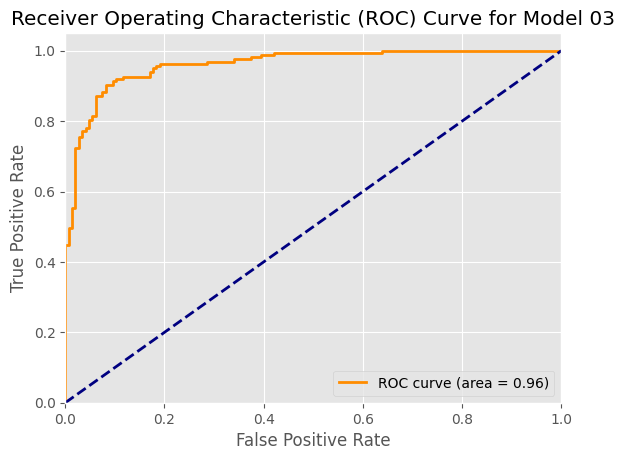

In [100]:
# prompt: plot the roc curve of model 3

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class (class 1)
# This assumes the second column of the prediction output corresponds to the positive class
y_pred_proba_03 = vgg_prediction_03[:, 1]

# Calculate the false positive rate (fpr) and true positive rate (tpr) for model_03
fpr_03, tpr_03, thresholds_03 = roc_curve(y_true, y_pred_proba_03)

# Calculate the Area Under the Curve (AUC) for model_03
roc_auc_03 = auc(fpr_03, tpr_03)

# Plot the ROC curve for model_03
plt.figure()
plt.plot(fpr_03, tpr_03, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_03:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Model 03')
plt.legend(loc="lower right")
plt.show()


In [99]:
# prompt: calculate the AUC

from sklearn.metrics import roc_auc_score

# Calculate AUC for model_03
# We need the predicted probabilities for the positive class (tumorous)
# vgg_prediction_03 contains probabilities for both classes, in the order [non-tumorous, tumorous]
y_scores_03 = vgg_prediction_03[:, 1]

# Calculate AUC
auc_03 = roc_auc_score(y_true, y_scores_03)
print(f"\nAUC for Model 03: {auc_03}")



AUC for Model 03: 0.961938149492926
